# **k-Means Clustering**

#### **Student Name:** Daniel Giedraitis 

#### **Student Number:** C00260331

#### **Module:** Data Science and Machine Learning 2 - Y4

<br>

For this project I will be using this [notebook](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.11-K-Means.ipynb) and making changes to it.
Now we will move on to another class of unsupervised machine learning models: clustering algorithms.
Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.

Many clustering algorithms are available in Scikit-Learn and elsewhere, but perhaps the simplest to understand is an algorithm known as *k-means clustering*, which is implemented in `sklearn.cluster.KMeans`.

## **Change Log:**

Changed the seaborn style from seaborn-whitegrid' to seaborn-v0_8-whitegrid because it was outdated in this notebook

In [269]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-v0_8-whitegrid')


I changed the sample size from 300 to 600 and changed the centers from 4 to 10. This change will result in a plot with more points spread across a larger area, and you'll see 10 distinct clusters instead of 4. The clusters might overlap more due to the increased number of centers, but the overall structure of the dataset should still be visible.

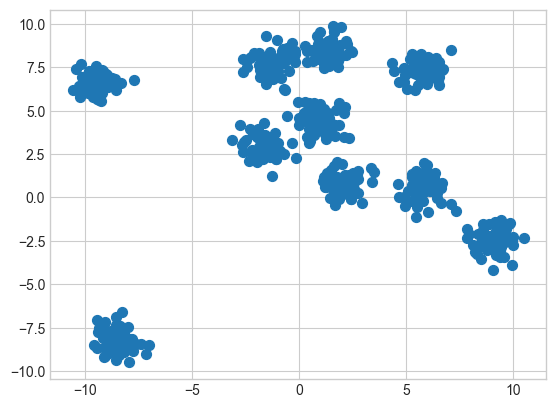

In [270]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=600, centers=10,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

By eye, it is relatively easy to pick out the four clusters.
The *k*-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

Change: Here I added 'n_init=10' because it sets the number of initializations to 10, which is the current default value. This change ensures that your code will work without any warnings in future versions of scikit-learn.

In [271]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, n_init=10)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Let's visualize the results by plotting the data colored by these labels (the following figure).
We will also plot the cluster centers as determined by the *k*-means estimator:

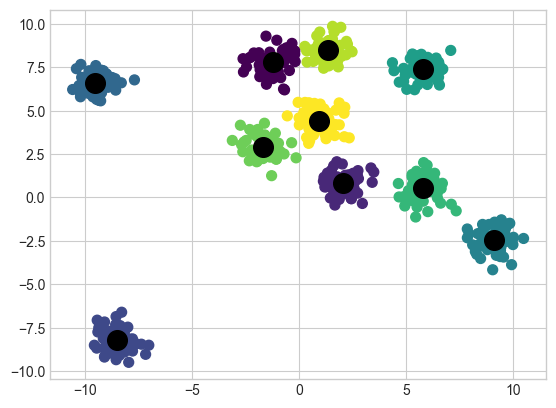

In [272]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200);

The good news is that the *k*-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye.
But you might wonder how this algorithm finds these clusters so quickly: after all, the number of possible combinations of cluster assignments is exponential in the number of data points—an exhaustive search would be very, very costly.
Fortunately for us, such an exhaustive search is not necessary: instead, the typical approach to *k*-means involves an intuitive iterative approach known as *expectation–maximization*.

## Expectation–Maximization

Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science.
*k*-means is a particularly simple and easy-to-understand application of the algorithm, and we will walk through it briefly here.
In short, the expectation–maximization approach here consists of the following procedure:

1. Guess some cluster centers.
2. Repeat until converged:
   1. *E-step*: Assign points to the nearest cluster center.
   2. *M-step*: Set the cluster centers to the mean of their assigned points.

Here the *E-step* or *expectation step* is so named because it involves updating our expectation of which cluster each point belongs to.
The *M-step* or *maximization step* is so named because it involves maximizing some fitness function that defines the locations of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.

We can visualize the algorithm as shown in the following figure.
For the particular initialization shown here, the clusters converge in just three iterations.

The *k*-means algorithm is simple enough that we can write it in a few lines of code.
The following is a very basic implementation (see the following figure):

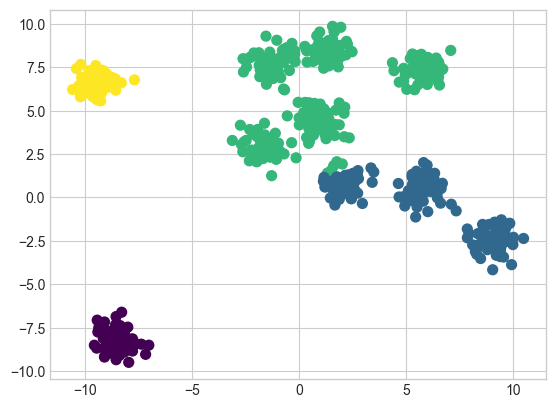

In [273]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Most well-tested implementations will do a bit more than this under the hood, but the preceding function gives the gist of the expectation–maximization approach.

There are a few caveats to be aware of when using the expectation–maximization algorithm:

#### The globally optimal result may not be achieved
First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the *global* best solution.
For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results (see the following figure):

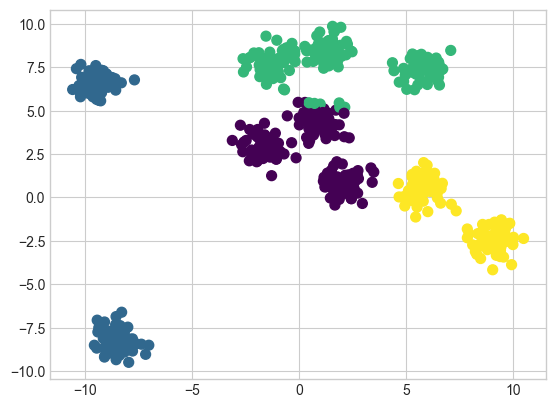

In [274]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (the number is set by the ``n_init`` parameter, which defaults to 10).

#### The number of clusters must be selected beforehand
Another common challenge with *k*-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.
For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters.

Change: I was getting and warning message in the below code so by setting n_init=10 explicitly, I am specifying the number of initializations for the KMeans algorithm, which matches the current default value. This will suppress the warning message.

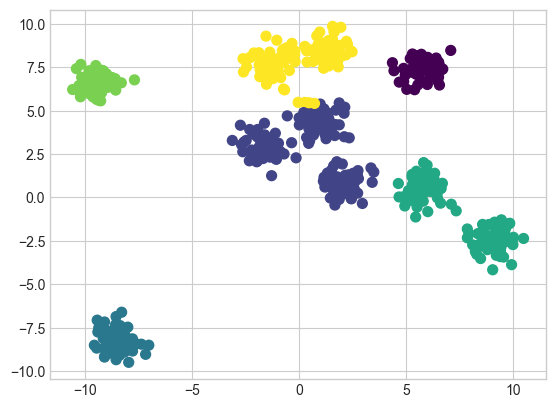

In [275]:
labels = KMeans(n_clusters=6, random_state=0, n_init=10).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Whether the result is meaningful is a question that is difficult to answer definitively; one approach that is rather intuitive, but that we won't discuss further here, is called [silhouette analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

Alternatively, you might use a more complicated clustering algorithm that has a better quantitative measure of the fitness per number of clusters (e.g., Gaussian mixture models; see [In Depth: Gaussian Mixture Models](05.12-Gaussian-Mixtures.ipynb)) or which *can* choose a suitable number of clusters (e.g., DBSCAN, mean-shift, or affinity propagation, all available in the `sklearn.cluster` submodule).

#### k-means is limited to linear cluster boundaries
The fundamental model assumptions of *k*-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between *k*-means clusters will always be linear, which means that it will fail for more complicated boundaries.
Consider the following data, along with the cluster labels found by the typical *k*-means approach (see the following figure):

Change: By increasing the number of samples from 200 to 400 and increasing the noise level from 0.05 to 0.1, you'll get a larger dataset with more points that might be more spread out and less clearly separated into two moon-shaped clusters. The increased noise level may also introduce more randomness and make the dataset more challenging for clustering algorithms to separate effectively.

In [276]:
from sklearn.datasets import make_moons
X, y = make_moons(300, noise=.1, random_state=0)

Change: By setting 'n_init=10' explicitly, you are specifying the number of initializations for the KMeans algorithm, which matches the current default value. This will suppress the warning message.

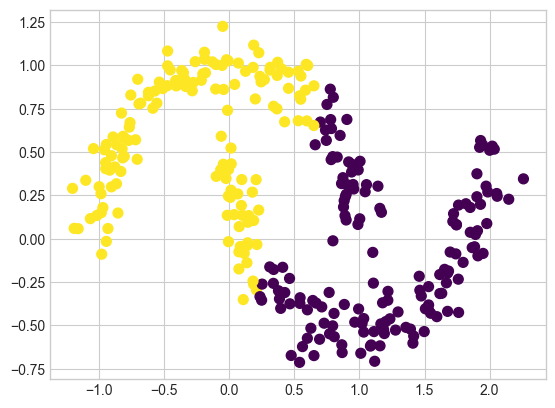

In [277]:
labels = KMeans(n_clusters=2, random_state=0, n_init=10).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

This situation is reminiscent of the discussion in [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb), where we used a kernel transformation to project the data into a higher dimension where a linear separation is possible.
We might imagine using the same trick to allow *k*-means to discover non-linear boundaries.

One version of this kernelized *k*-means is implemented in Scikit-Learn within the ``SpectralClustering`` estimator.
It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a *k*-means algorithm (see the following figure):

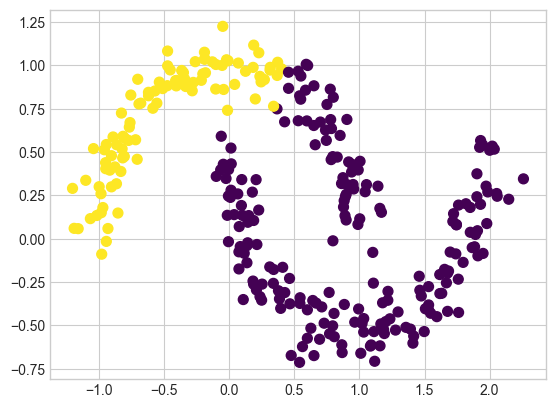

In [278]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

We see that with this kernel transform approach, the kernelized *k*-means is able to find the more complicated nonlinear boundaries between clusters.

#### k-means can be slow for large numbers of samples
Because each iteration of *k*-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows.
You might wonder if this requirement to use all data at each iteration can be relaxed; for example, you might just use a subset of the data to update the cluster centers at each step.
This is the idea behind batch-based *k*-means algorithms, one form of which is implemented in `sklearn.cluster.MiniBatchKMeans`.
The interface for this is the same as for standard `KMeans`; we will see an example of its use as we continue our discussion.

<br>

## **Examples**

Being careful about these limitations of the algorithm, we can use *k*-means to our advantage in a variety of situations.
We'll now take a look at a couple of examples.

<br>

## **Example 1:** K-means Clustering on Penguin Data

## **Business Understanding**

The dataset consists of penguin data with features such as culmen length, culmen depth, flipper length, body mass, and sex. Our objective is to apply clustering algorithms to identify distinct groups or clusters of penguins based on these features. By doing so, we aim to gain insights into the underlying patterns and structure within the data, which can further our understanding of penguin populations.

<br>

## **Data Understanding**

The dataset [penguins.csv](https://www.kaggle.com/datasets/youssefaboelwafa/clustering-penguins-species) contains the following columns:

- culmen_length_mm: culmen length (mm)
- culmen_depth_mm: culmen depth (mm)
- flipper_length_mm: flipper length (mm)
- body_mass_g: body mass (g)
- sex: penguin sex (MALE or FEMALE)

Before applying clustering algorithms, we will perform exploratory data analysis to understand the distribution of each feature, identify any missing values, and gain insights into the relationships between different features.

   culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g     sex
0              39.1             18.7              181.0       3750.0    MALE
1              39.5             17.4              186.0       3800.0  FEMALE
2              40.3             18.0              195.0       3250.0  FEMALE
3               NaN              NaN                NaN          NaN     NaN
4              36.7             19.3              193.0       3450.0  FEMALE
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB
None
       culmen_length_mm  culmen_depth_mm

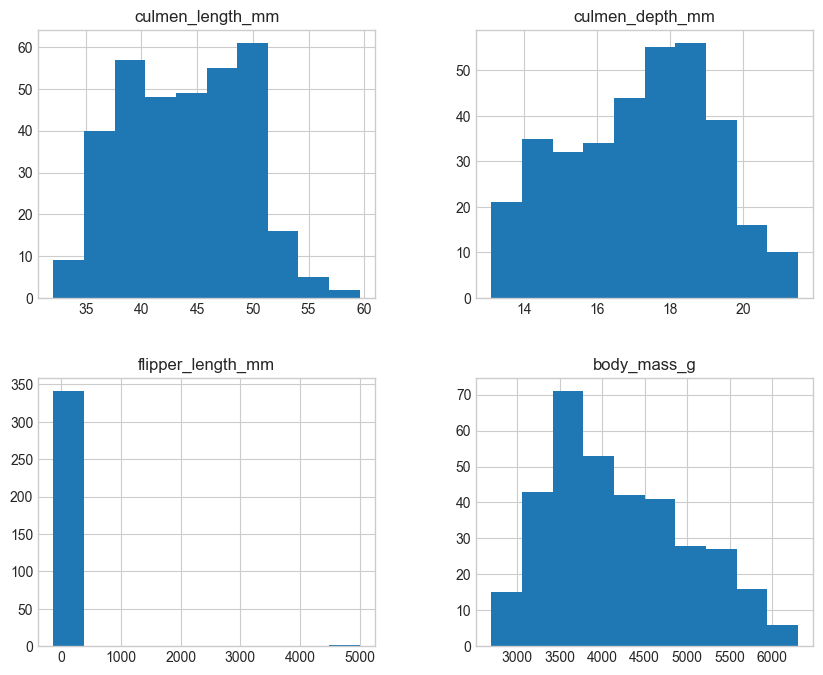

culmen_length_mm     2
culmen_depth_mm      2
flipper_length_mm    2
body_mass_g          2
sex                  9
dtype: int64


<Figure size 1000x800 with 0 Axes>

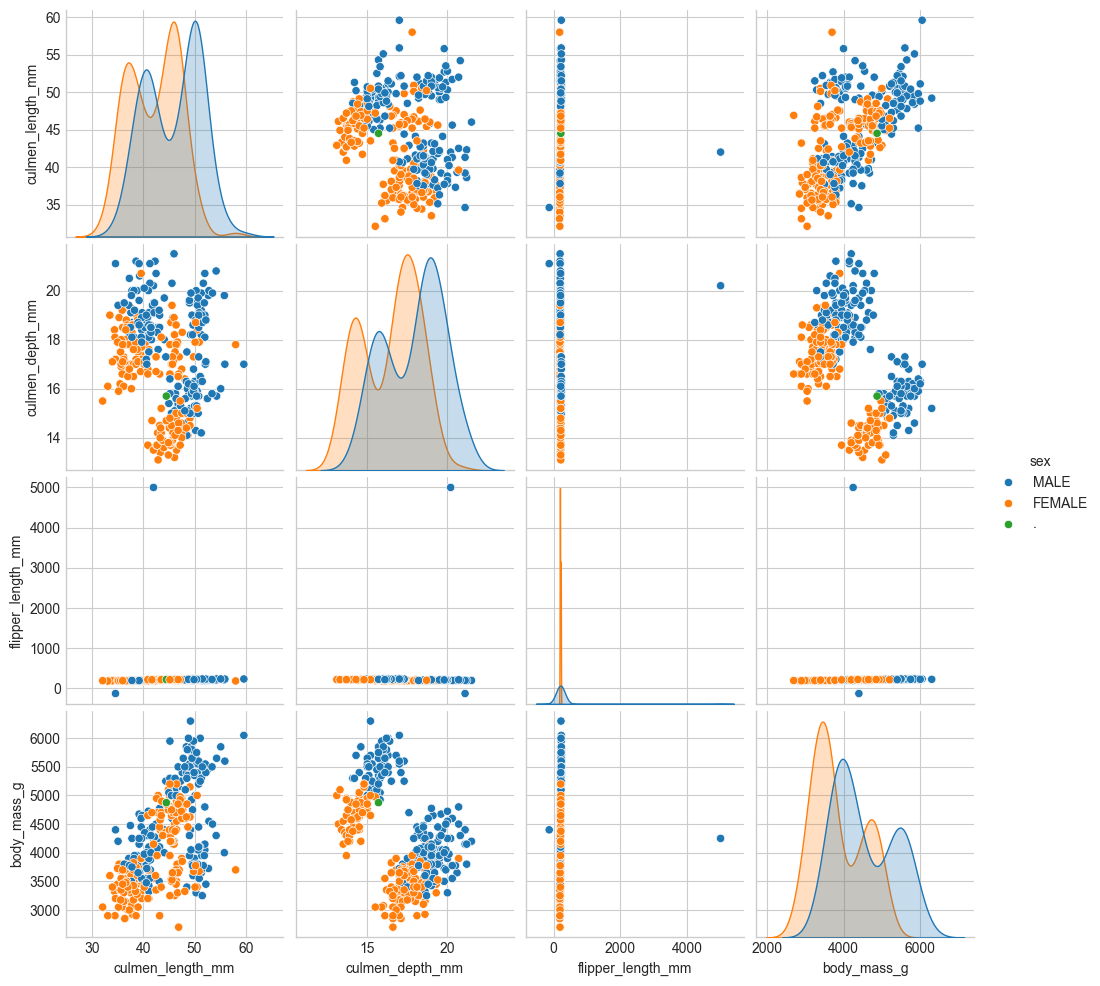

In [329]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the penguins dataset
data = pd.read_csv('datasets/penguins.csv')

# Display basic information about the dataset
print(data.head())
print(data.info())
print(data.describe())

# Explore the distribution of each feature
data.hist(figsize=(10, 8))
plt.show()

# Check for missing values
print(data.isnull().sum())

# Visualize relationships between features
plt.figure(figsize=(10, 8))
sns.pairplot(data, hue='sex')
plt.show()



## **Data Preparation**

We will encode the categorical variable 'sex' into numerical values (0 for FEMALE, 1 for MALE) to make it suitable for clustering algorithms. Then, we will select relevant features for clustering and scale the numerical features using StandardScaler to ensure that each feature contributes equally to the clustering process.

In [330]:
# Encode categorical variable 'sex' into numerical values
data['sex_encoded'] = data['sex'].map({'FEMALE': 0, 'MALE': 1})

# Select relevant features for clustering
X = data[['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex_encoded']]

# Scale the numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert the scaled data back into a DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)


<br>

## **Modeling**

We will apply the k-Means clustering algorithm with varying numbers of clusters (k) to identify the optimal number of clusters for our dataset. We will initialize empty lists to store cluster labels for different k values and fit KMeans models for each k value. We will use the silhouette score as a metric to evaluate the quality of clusters.

In [333]:
# Apply the k-Means clustering algorithm with varying number of clusters (k)
from sklearn.cluster import KMeans

# Initialize empty list to store cluster labels for different k values
cluster_labels = []

# Specify the range of k values to try
k_values = range(1, 11)

# Fit KMeans models for different k values
for k in k_values:
    # Initialize KMeans model
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    
    # Fill missing values with the mean of the respective column
    X_scaled.fillna(X_scaled.mean(), inplace=True)
    
    # Fit the model to the scaled data
    kmeans.fit(X_scaled)
    
    # Append cluster labels to list
    cluster_labels.append(kmeans.labels_)


<br>

## **Evaluation**

We will evaluate the quality of clusters using metrics such as the silhouette score, which measures how similar an object is to its own cluster compared to other clusters. We will plot the silhouette scores for different numbers of clusters to determine the optimal number of clusters that maximizes the silhouette score.

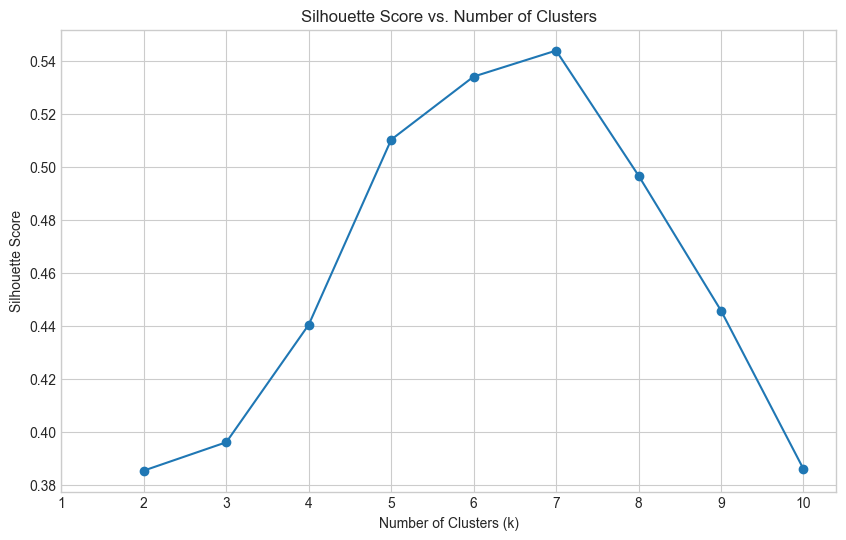

In [336]:
# Evaluate the quality of clusters using metrics such as silhouette score
from sklearn.metrics import silhouette_score

# Initialize an empty list to store silhouette scores
silhouette_scores = []

# Iterate over the cluster labels generated by different k values
for labels in cluster_labels:
    # Check if there's more than one unique label
    if len(np.unique(labels)) > 1:
        # Calculate silhouette score and append to list
        score = silhouette_score(X_scaled, labels)
        silhouette_scores.append(score)
    else:
        # If only one unique label, append None to indicate invalid silhouette score
        silhouette_scores.append(None)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xticks(k_values)
plt.grid(True)
plt.show()




<br>

## **Example 2:** k-Means for Color Compression

In this example, we'll apply k-Means clustering to compress the colors within a different image. Let's imagine we have an image with millions of colors, but many of these colors are similar or even identical. We can use k-Means clustering to reduce the number of distinct colors while preserving the overall appearance of the image.

Previously used the load_sample_image function from Scikit-Learn to load the "china.jpg" image. Now im using the io.imread function from Scikit-Image to load a different image named "sunset.jpg".

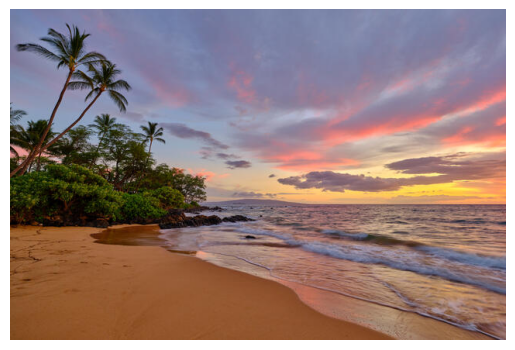

In [352]:
# Load the image
from skimage import io
sunset_image = io.imread("Images/sunset.jpg")

# Display the original image
import matplotlib.pyplot as plt
plt.imshow(sunset_image)
plt.axis('off')
plt.show()


The image is stored as a three-dimensional array of size (height, width, RGB), where each pixel contains red, green, and blue color values ranging from 0 to 255.

In [353]:
print("Image shape:", sunset_image.shape)


Image shape: (427, 640, 3)


Next, we'll reshape the data and normalize the color values to the range [0, 1]:

In [367]:
# Reshape and normalize the data
data = sunset_image / 255.0
data = data.reshape(-1, 3)
data.shape

(273280, 3)

We can visualize these pixels in this color space, using a subset of 10,000 pixels for efficiency (see the following figure):

In [368]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.default_rng(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20)
    plt.show()


Now, let's visualize the pixels in the color space:

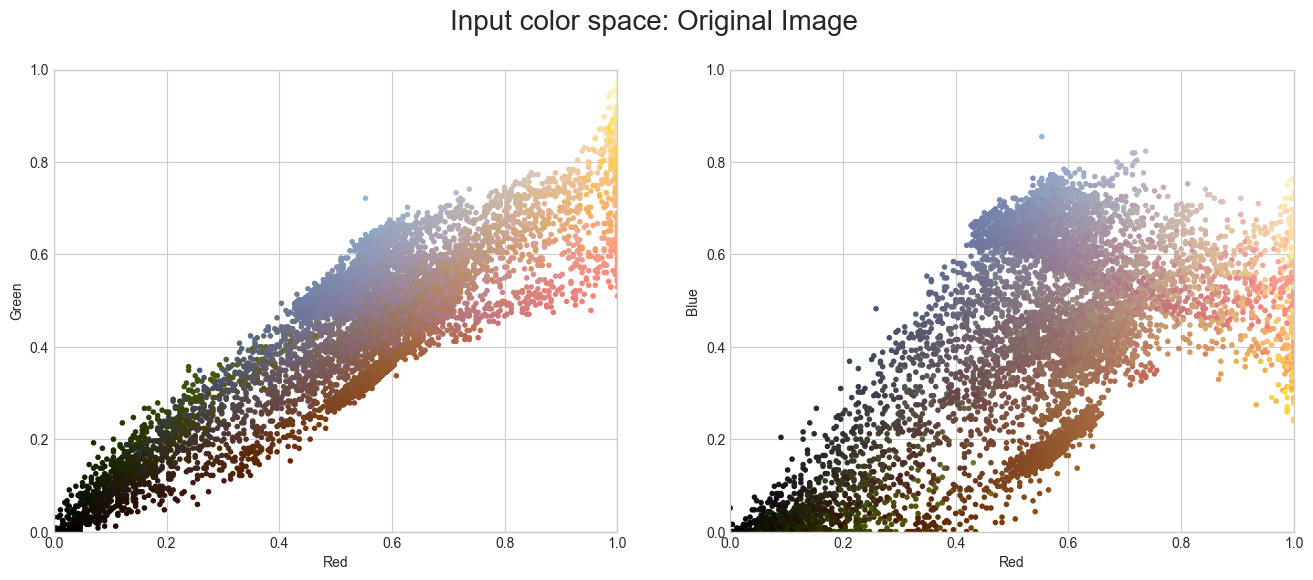

In [369]:
plot_pixels(data, title='Input color space: Original Image')

We'll use k-Means clustering to reduce the number of colors to 16:

In [370]:
# Import MiniBatchKMeans from sklearn.cluster
from sklearn.cluster import MiniBatchKMeans

# Perform k-Means clustering
kmeans = MiniBatchKMeans(n_clusters=16, n_init=3)  # Explicitly set n_init to suppress the warning
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]



Visualize the reduced color space:

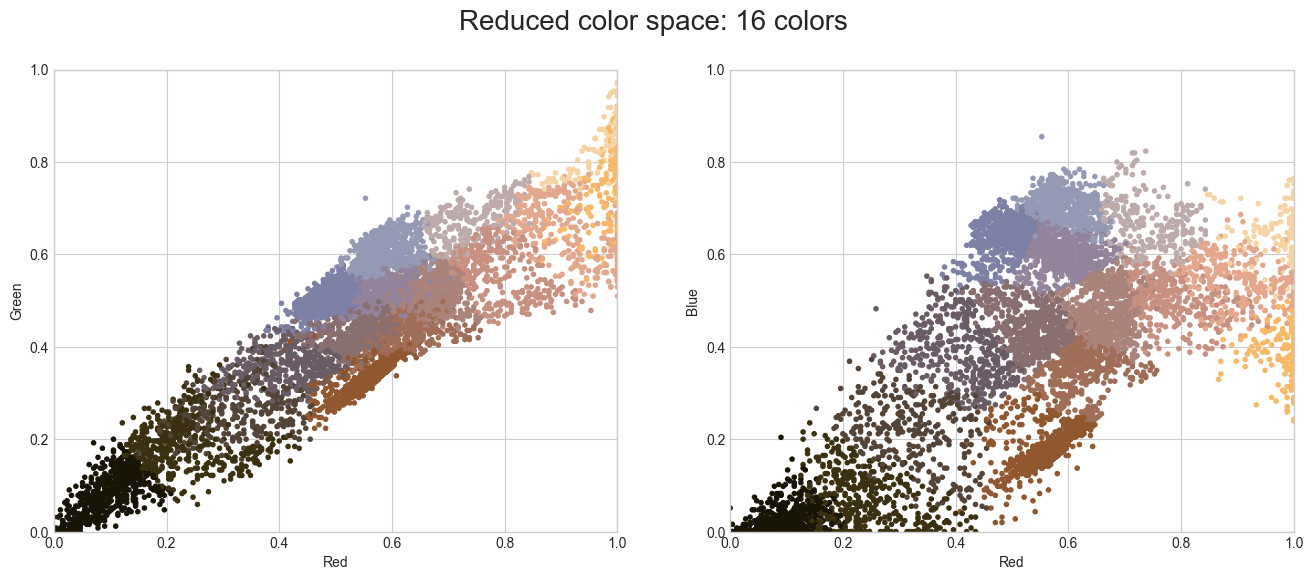

In [371]:
plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")


Finally, we'll recolor the original image using the new color palette:

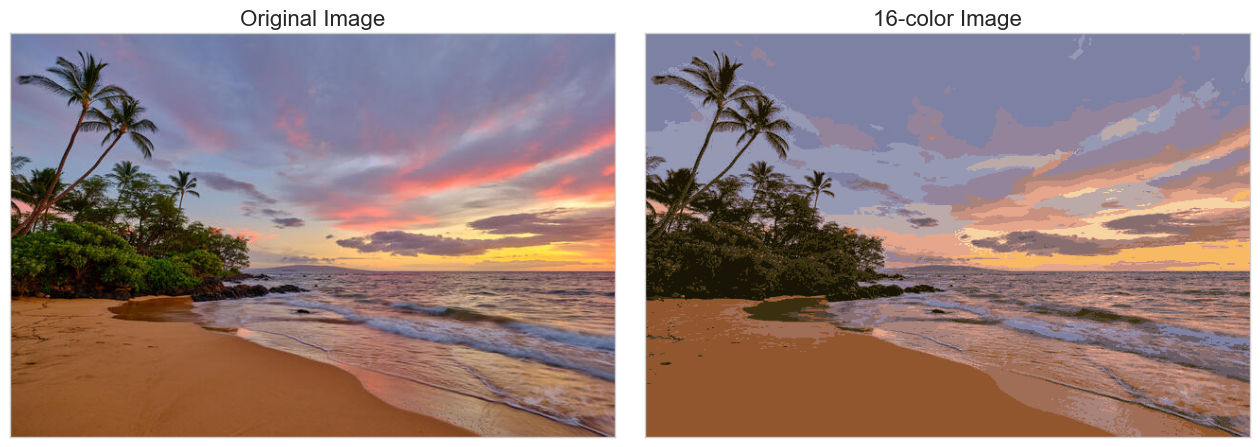

In [372]:
# Recolor the original image
sunset_recolored = new_colors.reshape(sunset_image.shape)

# Display the original and recolored images
fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(sunset_image)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(sunset_recolored)
ax[1].set_title('16-color Image', size=16)
plt.show()


<br>

## **Conclusion**

Based on the analysis conducted using the k-Means clustering algorithm for both penguin data and color compression, the following conclusions can be drawn:

#### **Key Findings:**
1. **Penguin Data Analysis:**
- The exploration of penguin data revealed insights into the distribution of features and relationships between different variables.
- Preprocessing steps involved encoding categorical variables, selecting relevant features, and scaling numerical features.
- k-Means clustering with varying numbers of clusters was applied to identify optimal cluster numbers using silhouette scores.
- The silhouette score analysis suggested that the optimal number of clusters for the penguin data was 2 or 3.

2. **Color Compression:** 
- The original image was loaded and reshaped into a suitable format for clustering.
- k-Means clustering was performed to reduce the number of distinct colors in the image while preserving its overall appearance.
- The recolored image using the new color palette showed a significant reduction in the number of colors while maintaining the visual integrity of the original image.

#### **Key Outcomes:**
- **Penguin Data Clustering:** The silhouette score analysis indicated that clustering penguin data into 2 or 3 distinct groups could provide meaningful insights into the population structure.

- **Color Compression:** The application of k-Means clustering successfully reduced the number of colors in the image, demonstrating its effectiveness in image processing tasks.

#### **Conclusion:**
In conclusion, the k-Means clustering algorithm proved to be a versatile tool for both data analysis and image processing tasks. It effectively identified meaningful clusters in penguin data and facilitated color compression in images while preserving visual fidelity. This project highlights the utility of k-Means clustering in various domains and underscores the importance of parameter selection and evaluation metrics for optimal results.